In [1]:
import datetime as dt
import os
import sys
sys.path.append(os.pardir)
from math import ceil

import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

from covid_19.utils import moving_average
from covid_19 import R0

In [2]:
confirmed_cases = np.loadtxt('../data/confirmed_cases.dat')
daily_tests = np.loadtxt('../data/tests.dat')
epidemics_start_date = dt.datetime(2020, 2, 26)
averaging_period = 16
testing_delay = 3
delay = averaging_period + testing_delay

In [3]:
R = R0.estimate(confirmed_cases, averaging_period, testing_delay)
R_averaging_period = int(averaging_period / testing_delay)
R_smoothed = moving_average(R, R_averaging_period)

lb_scaler, ub_scaler = R0.uncertainty_quantification(
    sensitivity=0.85, 
    specificity=0.95,
    confirmed_cases=confirmed_cases,
    daily_tests=daily_tests)

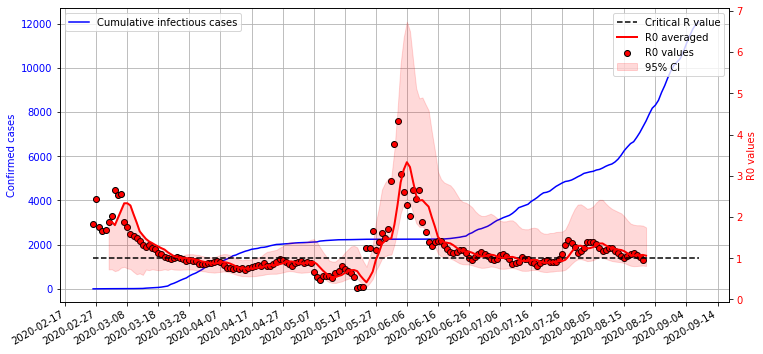

In [4]:
epidemics_duration = confirmed_cases.size
dates = mdates.drange(
    epidemics_start_date,
    epidemics_start_date + dt.timedelta(days=epidemics_duration), 
    dt.timedelta(days=1))
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111)
ax1.plot(dates, confirmed_cases, 'b-', label='Cumulative infectious cases')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylabel('Confirmed cases', color='blue')
ax1.legend()
ax1.grid(None)

ax2 = ax1.twinx()
ax2.scatter(dates[:-delay+1], R, color='red', edgecolor='black', label='R0 values')
ax2.plot(dates, np.ones(dates.shape), 'k--', label='Critical R value')
ax2.plot(dates[R_averaging_period:-delay+2], R_smoothed, 'r-', linewidth=2, label='R0 averaged')
ax2.fill_between(dates[R_averaging_period:-delay+2],
                 lb_scaler[R_averaging_period:-delay+2] * R_smoothed,
                 ub_scaler[R_averaging_period:-delay+2] * R_smoothed,
                 color='r', alpha=0.15, label='95% CI')
ax2.tick_params(labelcolor='r')
ax2.set_ylabel('R0 values', color='r')
ax2.legend()

fig.gca().xaxis.set_major_formatter(
    mdates.DateFormatter('%Y-%m-%d'))
fig.gca().xaxis.set_major_locator(
    mdates.DayLocator(interval=10))
fig.autofmt_xdate()
plt.show()